# Introduction

In this Notebook we will bw using **binary classification** to help us classify diamonds as 'Ideal' and 'Not Ideal', diamond diggers should then be able to find the right ***masterpiece***, and avoiding annoying non-ideal pieces.

> Notebook:
* google colaboratory(Jupyter - Python)

> Machine-Learning framework:
* Scikit-Learn

> Libraries:
* Pandas, numpy, matplotlib, seaborn


**diamond characteristics:**

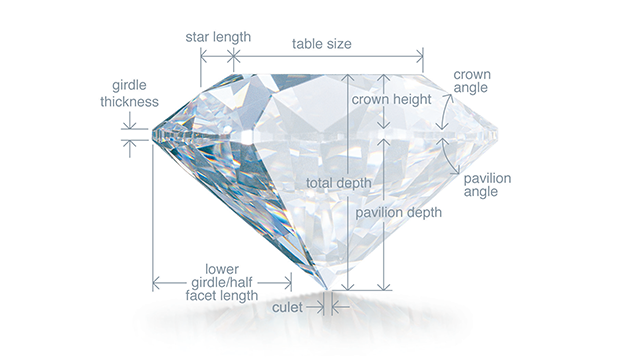

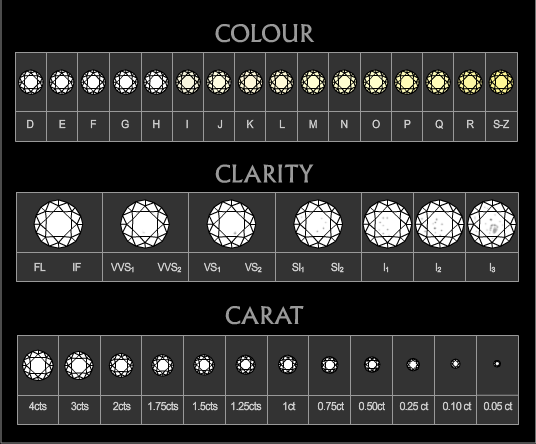

> **INDEX:**



1.   Data Cleaning and Visualization
2.   Preprocessing
3.   Model Building
4.   Metrics
5.   End


# 1. Data Cleaning and Visualization:

*uploading the data:*

In [140]:
# import colab.files to upload the data
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive (1).zip


In [141]:
# unzip the zip file
from zipfile import ZipFile
!unzip archive

Archive:  archive.zip
replace diamonds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: diamonds.csv            


In [142]:
# the data path is in /content/diamond.csv
import pandas as pd
data = pd.read_csv('diamonds.csv')

In [143]:
# let's take a look at the characteristics of the data
print("The number of data points is: " ,data.shape[0])
print("The number of features is: " , data.shape[1])
print("Features of the diamonds data are: \n" , list(data.columns))

The number of data points is:  53940
The number of features is:  11
Features of the diamonds data are: 
 ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


In [144]:
# how our dataframe does look like?
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


*cleaning:*

In [145]:
# get rid of the first useless column
data = data.drop(columns=['Unnamed: 0'])

# changing features names to be more readable 
# x length in mm  --> length
# y width in mm  --> width
# z depth in mm  --> depth
# depth = 100 * z / mean(x, y) (%) --> depth_m
features = ['weight', 'quality', 'color', 'clarity', 
            'depth_m', 'table','price', 'length', 'width', 'depth']
data.columns = features

# rearranging columns on purpose
data = data[['quality', 'color', 'clarity', 'price', 'table', 'weight', 'length', 'width', 'depth' , 'depth_m']]

In [146]:
# changing the names of categories of 'color' and 'clarity' columns
# using roman numbers in a scale of 1 to 8 , I: best --->  VIII: worst
categories_dict ={
    'color':       {'D':'excellent', 'E':'very good' , 'F':'good' , 'G':'fair' , 'H':'bad', 'I':'very bad' , 'J':'awful'},
    'clarity':       {'IF':'I', 'VVS1':'II', 'VVS2':'III', 'VS1':'IV', 'VS2':'V', 'SI1':'VI', 'SI2':'VII', 'I1':'VIII'},
}

for column in ['color' , 'clarity']:
  for key , value in categories_dict[column].items():
    mask = data[column] == key        # key is the old name
    data[column][mask] = value        # value is the new name

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [147]:
df1 = data[data.quality == 'Ideal']
df2 = data[data.quality != 'Ideal']

N = 20000
data = pd.concat((df1[:N] , df2[:N]))
data = data.sample(n = len(data))        # shuffling
data = data.reset_index(drop=True)              # reseting indices (0-->39999)

print("The new shape of the data: " , data.shape)

The new shape of the data:  (40000, 10)


In [148]:
# let's take a look again
data.head()

,quality,color,clarity,price,table,weight,length,width,depth,depth_m
0,Good,excellent,VII,3848,58.0,0.91,6.04,6.09,3.87,63.8
1,Ideal,very good,VII,427,56.0,0.32,4.42,4.44,2.70,61.0
2,Ideal,fair,VII,7240,57.0,1.53,7.44,7.41,4.58,61.7
3,Very Good,awful,V,3024,59.0,0.90,6.09,6.05,3.83,63.1
4,Premium,very bad,VI,4939,60.0,1.15,6.72,6.68,4.19,62.5


In [149]:
# Are there any missing data?
print("Is there any null value?")
print(data.isnull().any())

# what are the unique categories for each column in the categorical columns 
print(100*'*' ,'\n', "Unique categories for each column(categorical): ")
for column in data.columns[:3]:
  print(100*'_' ,'\n', data[column].unique())

# for the rest of columns that are continious, what are the data types
print(100*'*','\n' , "data types of columns(continuous)")
print(data.iloc[:,3:].dtypes)

Is there any null value?
quality    False
color      False
clarity    False
price      False
table      False
weight     False
length     False
width      False
depth      False
depth_m    False
dtype: bool
**************************************************************************************************** 
 Unique categories for each column(categorical): 
____________________________________________________________________________________________________ 
 ['Good' 'Ideal' 'Very Good' 'Premium' 'Fair']
____________________________________________________________________________________________________ 
 ['excellent' 'very good' 'fair' 'awful' 'very bad' 'bad' 'good']
____________________________________________________________________________________________________ 
 ['VII' 'V' 'VI' 'IV' 'II' 'III' 'I' 'VIII']
**************************************************************************************************** 
 data types of columns(continuous)
price        int64
table      float64
we

*visualization and more cleaning:*

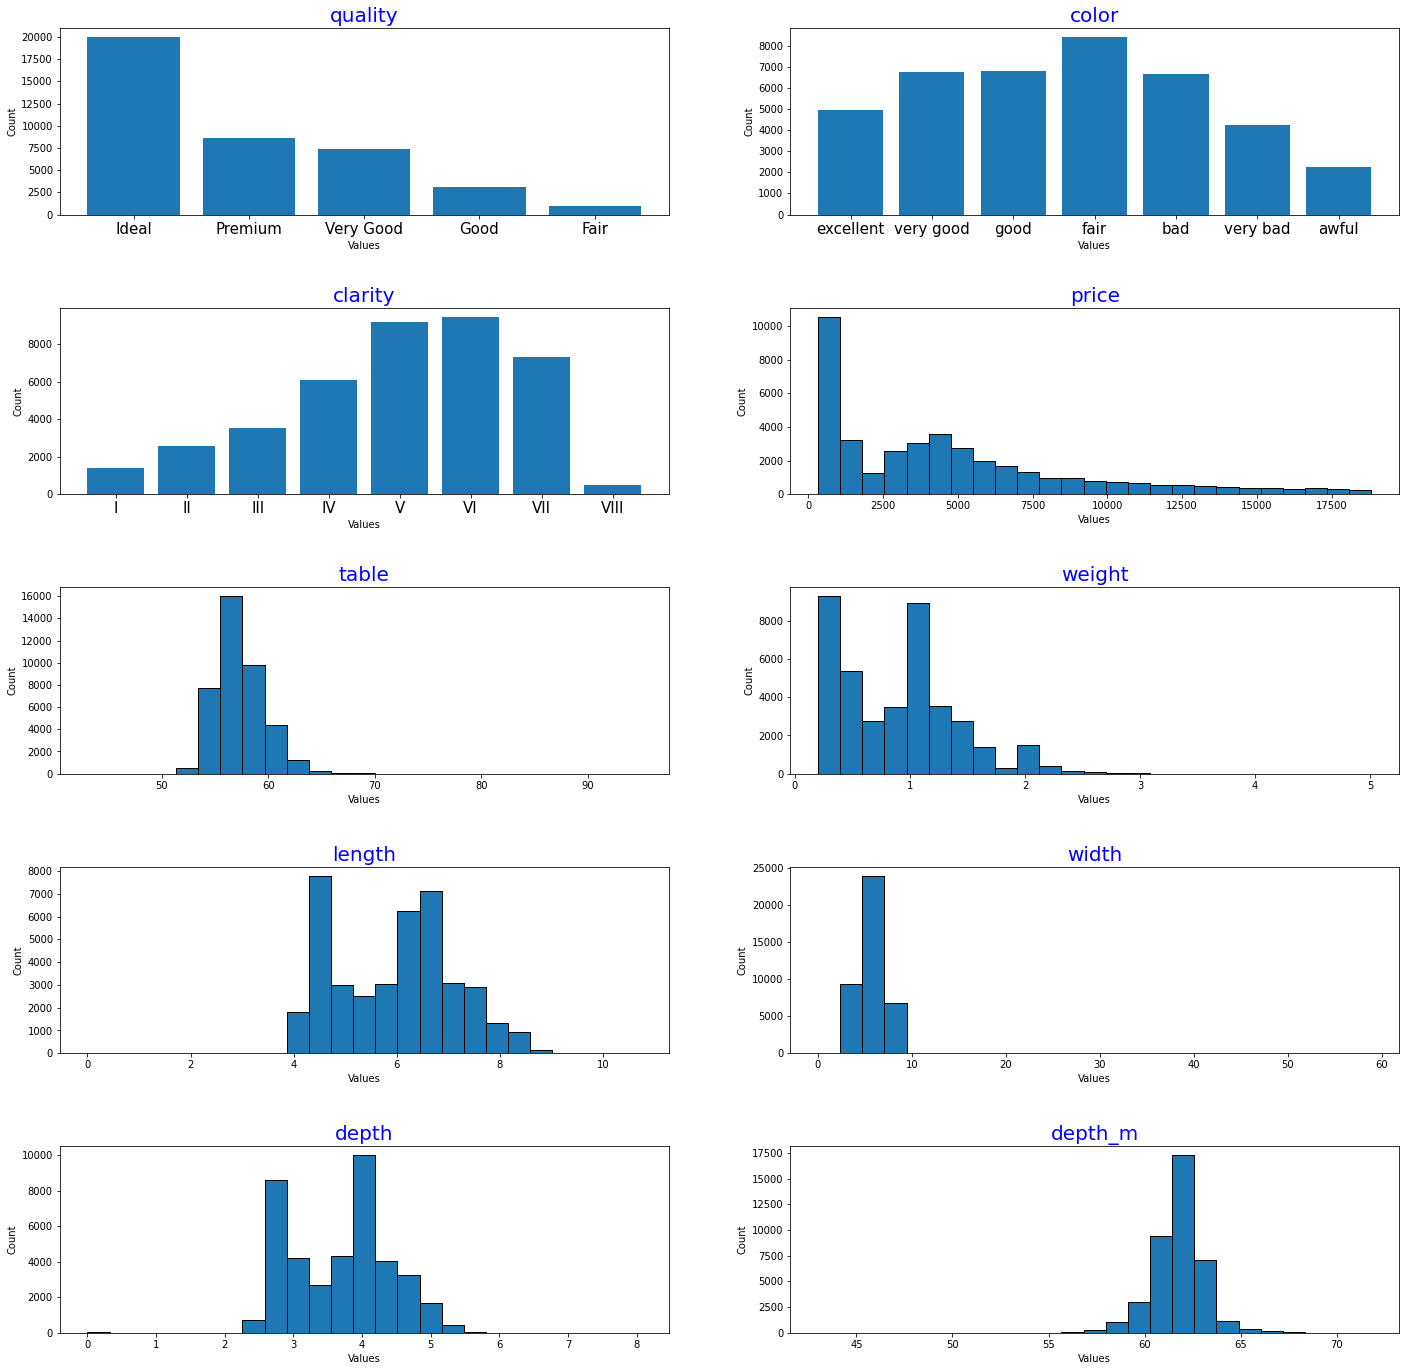

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# building a function that return the 
# count of each category in a given column of a given dataframe
def count_unique(data , column , categories):
  return np.array([np.sum(data[column] == category) for category in categories])

# sorting the labels for visualization purpose
quality_categories_sorted = ['Ideal','Premium','Very Good','Good','Fair']
color_categories_sorted = ['excellent','very good','good','fair','bad','very bad','awful']
clarity_categories_sorted = ['I','II','III','IV','V','VI','VII','VIII']
l = [quality_categories_sorted , color_categories_sorted , clarity_categories_sorted ]

fig , axes = plt.subplots(5,2 , figsize=(24,24))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

# plotting the Categorical data
for column , categories , ax  in zip(data.columns[:3] , l , axes.ravel()[:3]):
  count = count_unique(data=data , column=column , categories=categories)
  ax.bar(categories , count)
  ax.set_title(column , fontdict={'color':'b' , 'fontweight':8 , 'fontsize':20 })
  ax.set_xticklabels(categories , fontdict={'fontsize':15})
  ax.set_xlabel("Values")
  ax.set_ylabel("Count")

# plotting the Continious data
for column , ax in zip(data.columns[3:] , axes.ravel()[3:]):
  ax.hist(data[column] , bins = 25 , edgecolor = 'k')
  ax.set_title(column , fontdict={'color':'b' , 'fontweight':8 , 'fontsize':20 })
  ax.set_xlabel("Values")
  ax.set_ylabel("Count")
  
plt.show()

In [151]:
# Demonstration of the presence of some Noisy data points
# a very few points that are so far from the rest

#example of depth
print("data.depth > 7 :\n")
display(data[data.depth > 7].depth)

print('\n')
#example of length
print("data.length <3 :\n")
display(data[data.length <3].length)

data.depth > 7 :



29152    8.06
Name: depth, dtype: float64



data.length <3 :



443      0.0
10461    0.0
21378    0.0
28036    0.0
38101    0.0
38119    0.0
Name: length, dtype: float64

In [152]:
# preventing the data points from reaching some unpleasent values   
limits = {'table':(53,63) , 'weight':(0.1,3) , 'length':(3.8,9) , 
                'width':(1,10) , 'depth':(2,6) , 'depth_m':(56,68)}
for feature in limits.keys():
  mask = (data[feature] >= limits[feature][0])  &  (data[feature] <= limits[feature][1])
  data = data[mask]

In [153]:
# reducing the price categories from five to two
# to be able to perform a (Binary Classification)
# Negative Class: Not Ideal 
# Positive Class: Ideal

mask = data.quality == 'Ideal'
data.quality[~mask] = 'Not Ideal'

# percentage
x = 100 * sum(mask)/len(data)
y = 100 - x
print("The percentage of  'Ideal' class:  {:.2f}%".format(x))
print("The percentage of  'Not Ideal' class:  {:.2f}%".format(y))

The percentage of  'Ideal' class:  50.59%
The percentage of  'Not Ideal' class:  49.41%


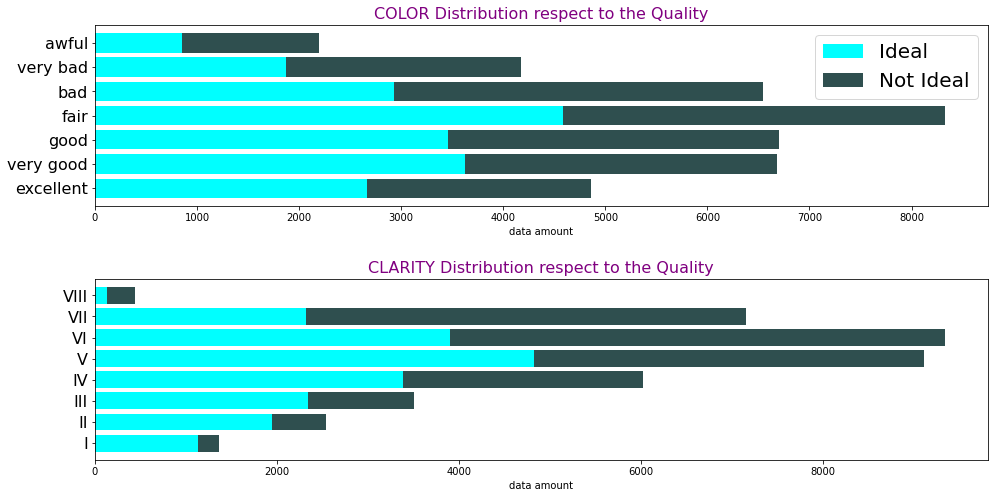

In [154]:
# plotting the 'Ideal' against 'Not Ideal' 
# data amount for each category in ('color' and 'clarity)

data_i = data[mask]
data_n = data[~mask]

color_Ideal_count = count_unique(data_i , 'color' , color_categories_sorted)
color_not_Ideal_count = count_unique(data_n , 'color' , color_categories_sorted)
clarity_Ideal_count = count_unique(data_i , 'clarity' , clarity_categories_sorted)
clarity_not_Ideal_count = count_unique(data_n , 'clarity' , clarity_categories_sorted)

fig , ax = plt.subplots(2,1,figsize=(16,8))
plt.subplots_adjust(hspace = 0.4)

ax[0].barh(color_categories_sorted , color_Ideal_count , color='aqua')
ax[0].barh(color_categories_sorted , color_not_Ideal_count , left=color_Ideal_count , color='darkslategrey')
ax[0].set_title("COLOR Distribution respect to the Quality" , fontdict={'fontsize':16 , 'color':'purple'})
ax[0].set_yticklabels(color_categories_sorted  , fontdict={'fontsize':16})
ax[0].set_xlabel("data amount")
ax[0].legend(["Ideal" , "Not Ideal"] , loc="best" , prop={'size': 20})

ax[1].barh(clarity_categories_sorted , clarity_Ideal_count , color='aqua')
ax[1].barh(clarity_categories_sorted , clarity_not_Ideal_count , left=clarity_Ideal_count , color='darkslategrey')
ax[1].set_title("CLARITY Distribution respect to the Quality" , fontdict={'fontsize':16 , 'color':'purple'})
ax[1].set_yticklabels(clarity_categories_sorted  , fontdict={'fontsize':16})
ax[1].set_xlabel("data amount")

plt.show()

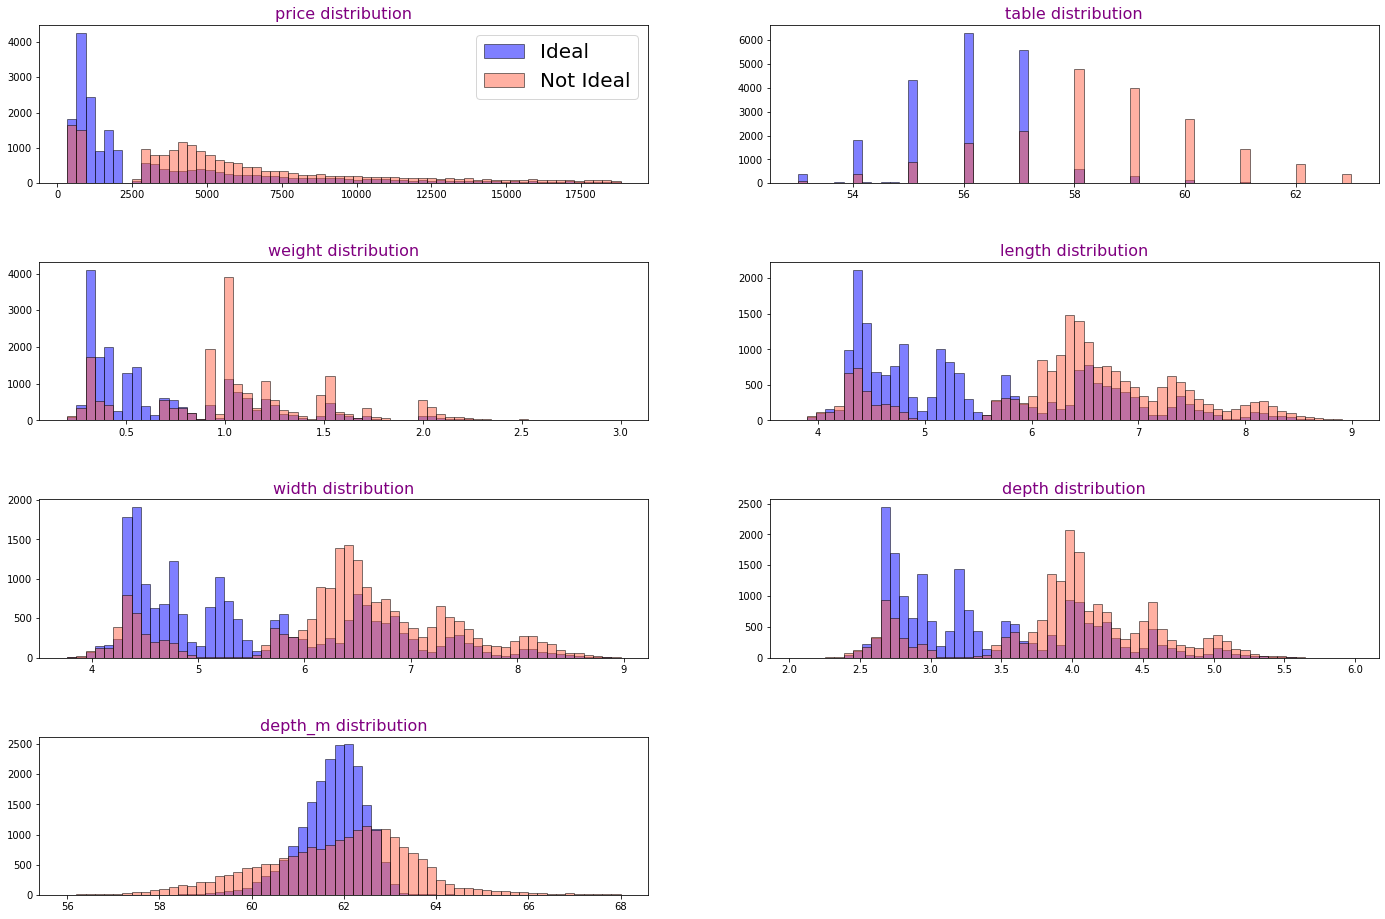

In [155]:
# plotting data continious columns distributions 
# corresponding to 'Ideal' vs 'Not Ideal' classes 
fig , axes = plt.subplots(4,2 , figsize=(24,16))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

for column , ax in zip(data.columns[3:] , axes.ravel()):
  hist,bins = np.histogram(data[column] , bins = 60)
  ax.hist(data_i[column] , bins = bins , alpha = 0.5 , color='b' , edgecolor='k')
  ax.hist(data_n[column] , bins = bins , alpha = 0.5 , color='tomato' , edgecolor='k')
  ax.set_title("{} distribution".format(column) , fontdict={'fontsize':16 , 'color':'purple'})

axes[0,0].legend(['Ideal','Not Ideal'] , loc="best" , prop={'size': 20})
axes[-1,-1].axis('off')
plt.show()

# 2. Preprocessing:

*first example of categorical encoding:*

In [156]:
# first example
# how does "encoding categorical variables" work

df = pd.DataFrame({'food': ['fish' , 'fish' , 'meet'] , 'color' : ['blue' , 'green' , 'yellow']})
print(df)
print('\n\n')
print(pd.get_dummies(df))

   food   color
0  fish    blue
1  fish   green
2  meet  yellow



   food_fish  food_meet  color_blue  color_green  color_yellow
0          1          0           1            0             0
1          1          0           0            1             0
2          0          1           0            0             1


*OneHotEncoder:*

In [157]:
# OneHotEncoder provided by scikit-learn is more useful
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False) 
# encoding categorical variables
encoder.fit(data[['color' , 'clarity']])   
X_cat = encoder.transform(data[['color' , 'clarity']])
# X_cat contains the new encoded data of ('color' and 'clarity')

In [158]:
# we'v got 7 + 8 columns with features of form 'OldFeature_categoriy'
# taking values in [0,1]
encoded_features = encoder.get_feature_names()
print("the number of categorical columns after encoding: ",len(encoded_features))
print("their names: ",list(encoded_features))
print("X_cat shape: ", (X_cat.shape))
print("first five rows of X_cat: \n" , X_cat[:5])
print("all rows sum to 2 (= number of old features): ", 0 == sum(X_cat.sum(axis = 1) != 2) )

the number of categorical columns after encoding:  15
their names:  ['x0_awful', 'x0_bad', 'x0_excellent', 'x0_fair', 'x0_good', 'x0_very bad', 'x0_very good', 'x1_I', 'x1_II', 'x1_III', 'x1_IV', 'x1_V', 'x1_VI', 'x1_VII', 'x1_VIII']
X_cat shape:  (39482, 15)
first five rows of X_cat: 
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
all rows sum to 2 (= number of old features):  True


In [159]:
# after encoding, we take back the encoded data and 
# concatenate it all with the continious columns

# new features list names
features = np.concatenate((data.columns[3:] , encoded_features))

X_con = np.array(data.iloc[:,3:])    # transform to numpy array
X = np.hstack((X_con , X_cat))    # concatenate horizontally

# the target vector " 0 for 'Not Ideal' and 1 for 'Ideal' "
mask = data['quality'] == 'Ideal'
y = np.array(mask , dtype=np.uint8)    

*Dimensionality Reduction (for visualization purpose):*

In [160]:
# reducing the dimonsionality of our data matrix to "2D" using Principale Component analysis
# in order to get an insight into the partition of the data
# since we already have 22 features which is not too much we dont have to hold the gotten result
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)
print("The shape of X_pca: ", X_pca.shape)
print("first five rows after transforming:\n", X_pca[:5])

The shape of X_pca:  (39482, 2)
first five rows after transforming:
 [[ 0.38654254 -1.0117076 ]
 [-2.51823712 -0.73033726]
 [ 2.71807706  1.66973475]
 [ 0.50779768 -0.21812512]
 [ 1.69888537 -1.41821794]]


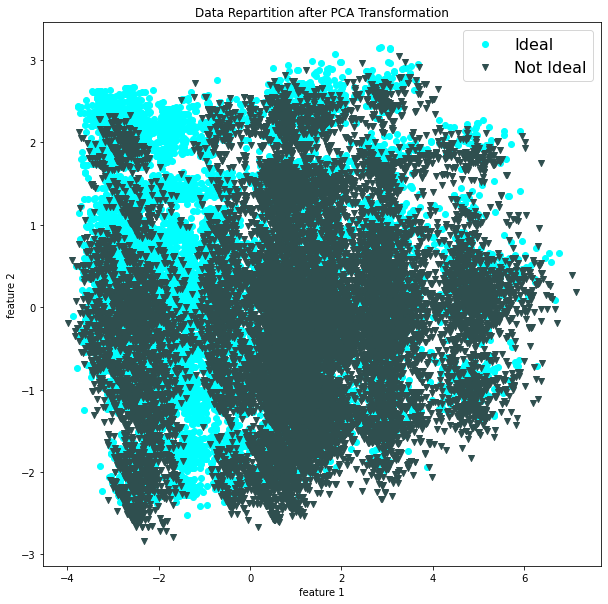

In [161]:
# plot a scatter of X_pca against the target
plt.figure(figsize=(10,10))
plt.scatter(X_pca[mask][:,0] , X_pca[mask][:,1] , c='aqua' , marker='o')
plt.scatter(X_pca[~mask][:,0] , X_pca[~mask][:,1] , c='darkslategrey' , marker='v')
plt.title("Data Repartition after PCA Transformation")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["Ideal" , "Not Ideal"] , loc="best" , prop={'size':16})
plt.show()

In [162]:
%%time
# T-Sne is more efficient than PCA but does no have a transformation method
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2 , n_jobs = -1 , random_state = 12345)
X_tsne = tsne.fit_transform(X)
print("The shape of X_tsne: ", X_tsne.shape)
print("first five rows of X_tsne:\n", X_tsne[:5])
print('\n\n')

The shape of X_tsne:  (39482, 2)
first five rows of X_tsne:
 [[-79.161674   8.404333]
 [-17.607227 -14.949454]
 [ 70.23004   31.006224]
 [ 34.053585 -41.623116]
 [ 58.648735 -19.302204]]



CPU times: user 12min 50s, sys: 1.02 s, total: 12min 51s
Wall time: 6min 31s


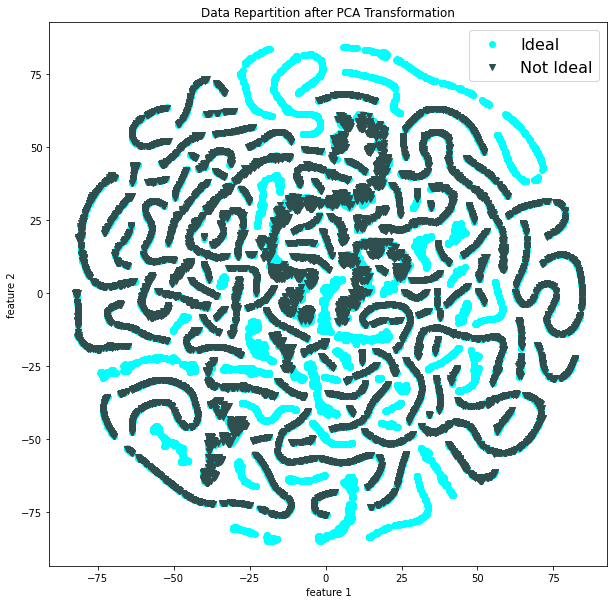

In [163]:
# plot a scatter of X_tsne against the target
plt.figure(figsize=(10,10))
plt.scatter(X_tsne[mask][:,0] , X_tsne[mask][:,1] , c='aqua' , marker='o')
plt.scatter(X_tsne[~mask][:,0] , X_tsne[~mask][:,1] , c='darkslategrey' , marker='v')
plt.title("Data Repartition after PCA Transformation")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["Ideal" , "Not Ideal"] , loc="best" , prop={'size':16})
plt.show()

*Features Importances:*

In [164]:
# SelectPercentile return the most important features  for a given percentile
# these features that have the most impact on the target
# using f1_score(default)
from sklearn.feature_selection import SelectPercentile
select = SelectPercentile(percentile = 25)  # most important 22 * 25% features
select.fit(X , y)
support = select.get_support()
print("the most important six features are: ", features[support])

the most important six features are:  ['price' 'table' 'weight' 'length' 'width' 'depth']


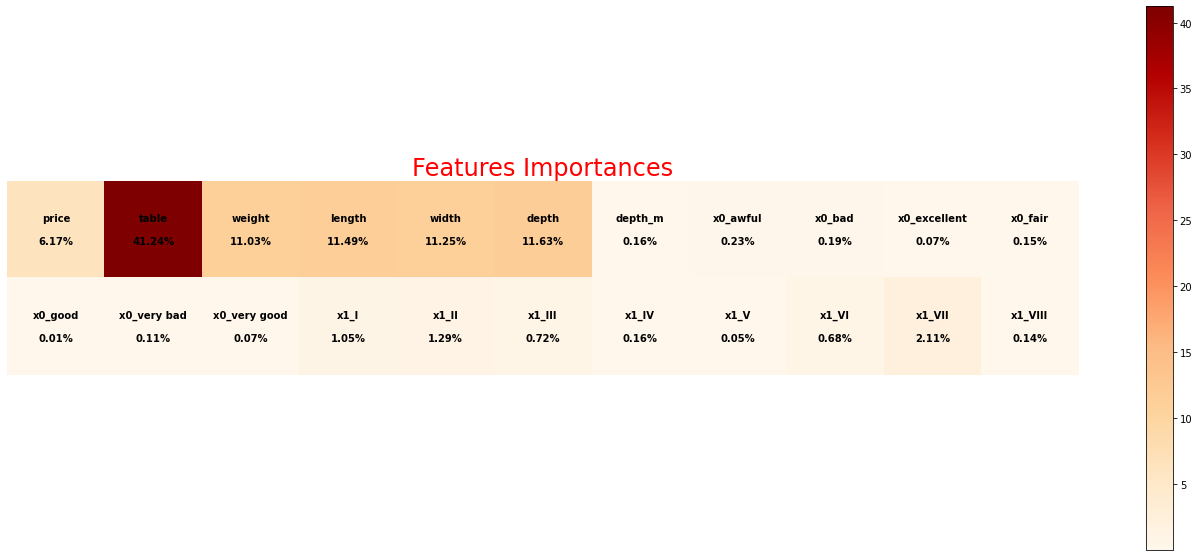

In [165]:
# plotting features with their importances
# the scores method return the scores

scores = 100 * select.scores_/np.sum(select.scores_)
scores = np.around(scores , decimals=2)
labels = np.array(["{}\n\n{}%".format(name , num) for name,num in zip(features,scores)])


figure = plt.figure(figsize=(24,10))
cmap = plt.imshow(scores.reshape(2,11) , cmap='OrRd')
plt.colorbar(cmap)
for i in range(2):
  for j in range(11):
    plt.text(j , i , labels.reshape(2,11)[i,j] , ha='center' , va='center' ,
             color='k' , fontdict={'fontweight':'bold'})
plt.title("Features Importances" , fontdict={'color':'r' , 'fontsize':24})

plt.axis('off')
plt.show()

*Clustering (First Insight):*

In [166]:
# using KMeans algorithm for clustering, to see if the data is can be 
# really divided to tow distinct classes with the same(or close) magnitudes as given by 'y'

# will KMeans succeed to spot and cluster the 'Ideal' and 'Not Ideal' classes ?

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [167]:
# count
target , count = np.unique(y_kmeans , return_counts=True)
print("the returned targets by KMeans are: " , target)
print("their corresponding populations: " , count)

the returned targets by KMeans are:  [0 1]
their corresponding populations:  [30549  8933]


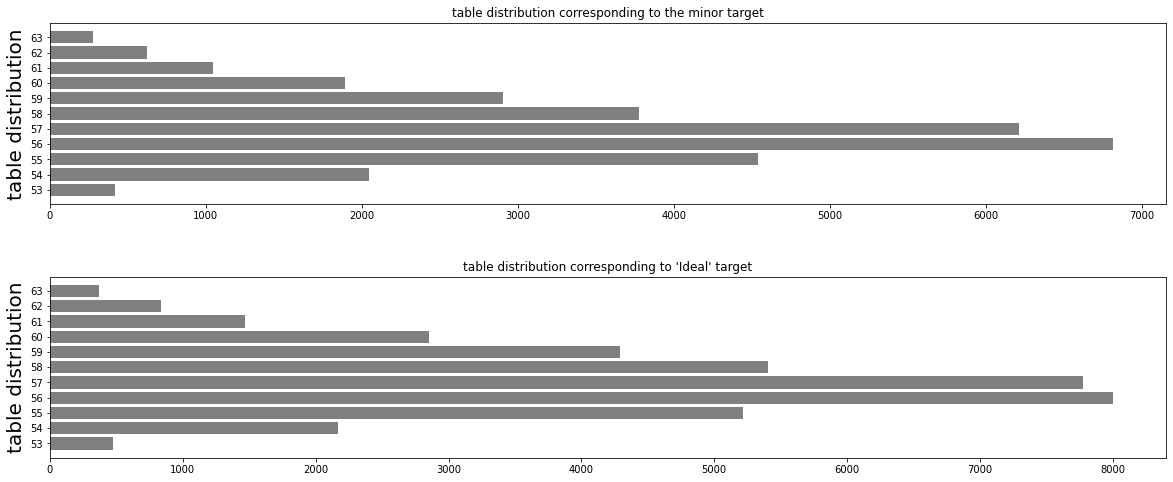

In [168]:
# plotting the table corresponidng to the target with less population
# we will see if it has the same distribution as corresponding the 'Ideal' class
# does KMeans succeed to spot the 'Ideal' and 'Not Ideal' classes ?

minor_target = target[0] if count[0]>count[1] else target[1]

table = np.around(data.table)
table_minor_target = table[y_kmeans == minor_target]
values , count = np.unique(table_minor_target , return_counts=True)
c_i = count_unique(data , 'table' , values)

fig , ax = plt.subplots(2 , 1 ,figsize=(20,8))
plt.subplots_adjust(hspace = 0.4)

ax[0].barh(values , count , color='grey')
ax[0].set_yticks(range(53,64))
ax[0].set_ylabel("table distribution" , fontdict={'fontsize':20})
ax[0].set_title("table distribution corresponding to the minor target")

ax[1].barh(values , c_i , color='grey')
ax[1].set_yticks(range(53,64))
ax[1].set_ylabel("table distribution" , fontdict={'fontsize':20})
ax[1].set_title("table distribution corresponding to 'Ideal' target" )


plt.show()


# 3. Bulding Models:

*train_test_split:*

In [169]:
# split the data to a training data and testing data
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 33333)

* First Try | **K-Nearest Neighbors**: 

In [170]:
# first model K-NN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train , y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [171]:
print("the score of K-NN on training data using a single neighbor: " , knn.score(X_train , y_train))
print("testing data score: {:.3f}".format(knn.score(X_test , y_test)))

the score of K-NN on training data using a single neighbor:  1.0
testing data score:  0.8000844238075138


In [172]:
# KFold divides all the samples in k groups of samples, called folds of equal sizes.
# The prediction function is learned using k-1 folds, and the fold left out is used for test.
# cross validation returns the score for each split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits = 5 , shuffle=True)
cv_scores = cross_val_score(knn , X , y ,cv = kfold)
print("cross validation scores using five folds: " , cv_scores)
print('their mean: {:.4f}'.format(cv_scores.mean()))

cross validation scores using five folds:  [0.80055717 0.80549576 0.80547112 0.80205167 0.80547112]
their mean: 0.8038


In [173]:
# iterating over some values of n_neighbors and choose the one that gives the better cross_val score
# using cross validation in order to avoid overfitting(optimism) on a certain parameter on the testing data
%%time
best_score = 0
best_param = 0
for n_neighbors in range(1,10,2):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train , y_train)
  cv_scores = cross_val_score(knn , X_train , y_train ,cv = kfold)
  mean_score = cv_scores.mean()
  if mean_score > best_score:
    best_score = mean_score
    best_param = n_neighbors

print("best score in cross validation is: {:.3f}".format(best_score))
print("best parameter is n_neighbors = " , best_param)
print("test score using best parameter is: {:.3f}".format(knn.score(X_test , y_test)))
print('\n\n')

best score in cross validation is: 0.795
best parameter is n_neighbors =  1
test score using best parameter is: 0.788



CPU times: user 7.87 s, sys: 7.01 ms, total: 7.88 s
Wall time: 7.9 s


* Second Try | **Logistic Regression**:

In [174]:
# second model Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train , y_train)
print("Logistic Regression (default parameters): ")
print("Training Score: {:.3f}".format(lr.score(X_train , y_train)))
print("Testing Score: {:.3f}".format(lr.score(X_test,y_test)))

Logistic Regression (default parameters): 
Training Score:  0.7437493215616746
Testing Score 0.7501899535669059


In [175]:
# increasing the max_iter to help the algorithm converges,
# and using another solver that helps to avoid underfitting
lr = LogisticRegression(solver='newton-cg' , max_iter = 10000 , n_jobs=-1)
lr.fit(X_train , y_train)
print("Logistic Regression (newton): ")
print("Training Score: {:.3f}".format(lr.score(X_train , y_train)))
print("Testing Score: {:.3f}".format(lr.score(X_test,y_test)))

Logistic Regression (newton): 
Training Score: 0.833
Testing Score: 0.832


* Third Try | **Support Vector Machine**:

In [176]:
# third model Support Vector Machine Classifier
# SVC needs some data scaling (MinMax)
# MinMax scale each column so that it's values will belong to [0-1]
%%time
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC().fit(X_train_scaled, y_train)   #default parameter
print("SVC:")
print("training score: {:.3f}".format(svc.score(X_train_scaled , y_train)))
print("testing score: {:.3f}".format(svc.score(X_test_scaled , y_test)))
print('\n')

SVC:
training score: 0.860
testing score: 0.858


CPU times: user 52.6 s, sys: 230 ms, total: 52.8 s
Wall time: 52.9 s


*Grid Search:*

In [ ]:
# grid search does the same work we did earlier where we iterated over parameters of K-NN to choose the best one
# Pipleine healp us chaining the MinMaxScaler estimator with the SVC estimator
# DISCLAMER: this could take one hour
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler" , MinMaxScaler()) , ("svm" , SVC())])

C = [10**n for n in range(5)]
gamma = [10**n for n in range(-3,3)]
param = {'svm__C':C , 'svm__gamma':gamma}

k = KFold(n_splits=3 , shuffle = True)
grid = GridSearchCV(pipe , param_grid = param , cv = k , n_jobs=-1)

grid.fit(X_train,y_train)
print("Grid Search: \n")
print("The best parameters are: " , grid.best_params_)
print("The best score in cross validation is: {:.4f}".format(grid.best_score_))
print("Training Score: {:.4f}".format(grid.score(X_train,y_train)))
print("Testing Score: {:.4f}".format(grid.score(X_test,y_test)))
print('\n\n')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Grid Search: 

The best parameters are:  {'svm__C': 10, 'svm__gamma': 10}
The best score in cross validation is: 0.8824
Training Score: 0.9186
Testing Score: 0.8900



CPU times: user 1min 2s, sys: 229 ms, total: 1min 2s
Wall time: 58min 7s


In [ ]:
# visualizing the results of GridSearch
# mean cross_val score for each combination of parameters
result = pd.DataFrame(grid.cv_results_)
result = result[['param_svm__C' , 'param_svm__gamma' , 'mean_test_score']]
display(result.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
param_svm__C,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,1000,1000,1000,1000,1000,1000,10000,10000,10000,10000,10000,10000
param_svm__gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100
mean_test_score,0.766473,0.825596,0.840142,0.851648,0.873033,0.875385,0.82632,0.836668,0.857184,0.873214,0.882404,0.864457,0.836198,0.843,0.875927,0.879365,0.872345,0.851829,0.838007,0.860296,0.880342,0.881717,0.859609,0.847813,0.843435,0.876434,0.881608,0.878677,0.845208,0.846836


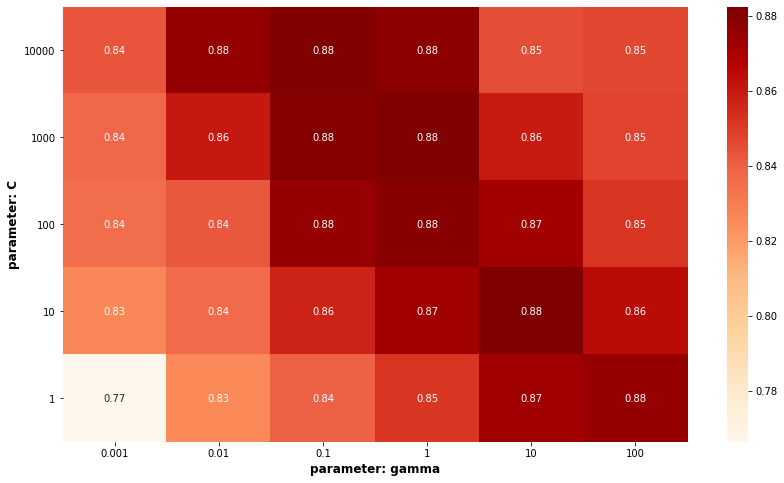

In [ ]:
# another visualization (heatmap)
scores = grid.cv_results_['mean_test_score'].reshape(5,6)[::-1]
import seaborn as sns
fig = plt.figure(figsize=(14,8))
sns.heatmap(scores , annot=True , cmap='OrRd')
plt.xticks(np.arange(6)+.5,labels=gamma)
plt.yticks(np.arange(5)+.5,labels=C[::-1] , rotation=0)
plt.xlabel("parameter: gamma" , 
           fontdict={'fontweight':'bold', 'fontsize':'larger' ,'color':'k'})
plt.ylabel("parameter: C" , 
           fontdict={'fontweight':'bold', 'fontsize':'larger' ,'color':'k'})
plt.show()

# 4. Metrics:

*Confusion Matrix:*

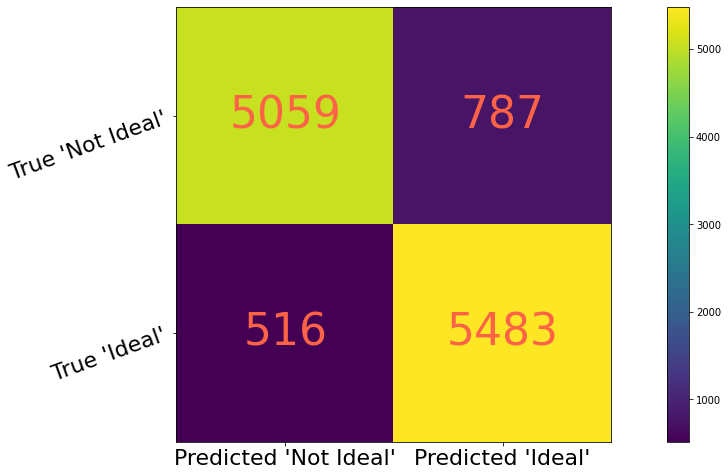

In [ ]:
# confusion matrix helps us know how many 'Non Ideal' diamonds in the testing data that classified as 'Ideal'
from sklearn.metrics import confusion_matrix
y_test_pred = grid.predict(X_test)
c_matrix = confusion_matrix(y_test , y_test_pred)

def plot_c_matrix(c_matrix):
  fig = plt.figure(figsize=(20,8))
  cmap = plt.imshow(c_matrix , cmap='viridis')
  plt.colorbar(cmap)
  for i in range(2):
    for j in range(2):
      plt.text(j , i , c_matrix[i,j] , ha='center' , va='center' ,
              fontdict={'color':'tomato'  , 'fontsize':44})

  plt.xticks([0,1] , labels=["Predicted 'Not Ideal'" , "Predicted 'Ideal'"] , fontsize=22)
  plt.yticks([0,1] , labels=["True 'Not Ideal'" , "True 'Ideal'"] , rotation=20 , fontsize=22)

  plt.show()

plot_c_matrix(c_matrix)

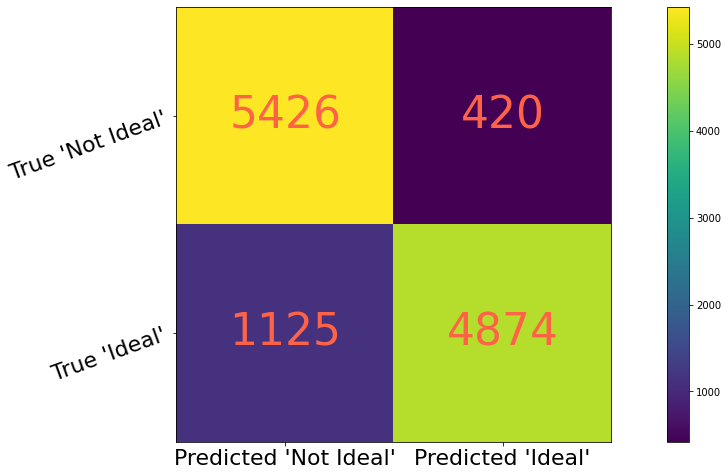

In [ ]:
# decision_function method by default:
# <0 classified as 'Not Ideal'(0) 
# >0 classified as 'Not Ideal'(1)

y_test_pred_high_thresh = grid.decision_function(X_test) > 0.7
# increasing the threshold 
# <0.7 classified as 'Not Ideal'(0) 
# >0.7 classified as 'Not Ideal'(1)

plot_c_matrix(confusion_matrix(y_test , y_test_pred_high_thresh)) 

In [ ]:
# classification_report provide a summary of recall and precision for each class
# increasing recall for a given class limits the other class points to classified as such a class (like increasing threshold does)
# the price to pay is the precision wich will obviously decrease
# f1_score is the harmonic mean of both
from sklearn.metrics import classification_report
print(classification_report(y_test , y_test_pred , 
      target_names = ["Not Ideal" , "Ideal"]))
print(60*'*')
print(classification_report(y_test , y_test_pred_high_thresh , 
      target_names = ["Not Ideal" , "Ideal"]))

              precision    recall  f1-score   support

   Not Ideal       0.91      0.87      0.89      5846
       Ideal       0.87      0.91      0.89      5999

    accuracy                           0.89     11845
   macro avg       0.89      0.89      0.89     11845
weighted avg       0.89      0.89      0.89     11845

************************************************************
              precision    recall  f1-score   support

   Not Ideal       0.83      0.93      0.88      5846
       Ideal       0.92      0.81      0.86      5999

    accuracy                           0.87     11845
   macro avg       0.87      0.87      0.87     11845
weighted avg       0.88      0.87      0.87     11845



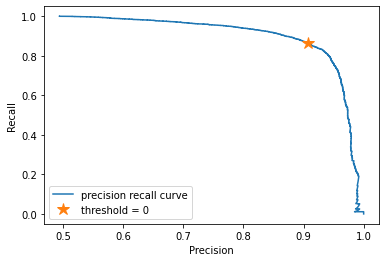

In [ ]:
# scikit-learn provides a precision_recall_curve function that gives these quantities for several thresholds
from sklearn.metrics import precision_recall_curve
precision , recall , thresholds = precision_recall_curve(
    ~np.array(y_test , dtype = bool) , -grid.decision_function(X_test))         # precision_recall_curve works by default for the positive classe(1)
                                                                                # so we reverse our values

zero_index = np.argmin(np.abs(thresholds))                                      # closest threshold to zero                      

plt.plot(precision , recall , label="precision recall curve")
plt.plot(precision[zero_index] , recall[zero_index] , '*' , markersize=12 , label="threshold = 0")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

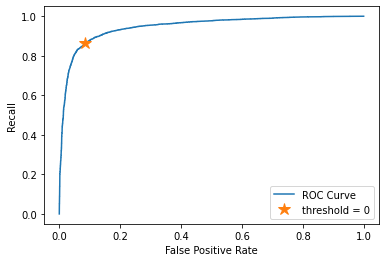

In [ ]:
# ROC_curve is similar to precision_recall_curve, instead of precision it uses 
# false positive rate wich has the same impact(lower is better)
from sklearn.metrics import roc_curve

false_positive_rate, recall, thresholds = roc_curve(
    ~np.array(y_test , dtype = bool), -grid.decision_function(X_test))
zero_index = np.argmin(np.abs(thresholds))

plt.plot(false_positive_rate, recall, label="ROC Curve")
plt.plot(false_positive_rate[zero_index] , recall[zero_index] , '*' , markersize=12 , label="threshold = 0")
plt.xlabel("False Positive Rate")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()
# note that ROC_curve is more popular and more efficient

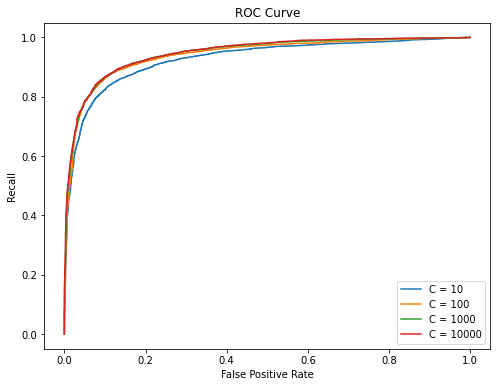

In [ ]:
# serching for the model having a ROC_curve integrande closest to one
gamma = 0.1
C_param = [10**n for n in range(1,5)]

fig = plt.figure(figsize=(8,6))
for C in C_param:
  svc2 = SVC(C=C , gamma=gamma).fit(X_train_scaled , y_train)
  fpr, recall, _ = roc_curve(
    ~np.array(y_test , dtype = bool), -svc2.decision_function(X_test_scaled))
  plt.plot(fpr , recall , label="C = {}".format(C))

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()
# the higher C The more convenient the model

# 5. End:

In [ ]:
# we are convinced the best model is the one given by Grid Search 
# and the suitable threshold is simply zero

# weight should be in carat
# length, width and depth should be in mm
# price should be in USD
# color and clarity should be given in their scientific form
def predict_quality(color, clarity, price,	table,	weight,	length,	width,	depth):
  depth_m = 100 * 2 * depth/(length+width)
  color = categories_dict['color'][color]
  clarity = categories_dict['clarity'][clarity]
  
  encoded = encoder.transform(np.array([[clarity , color]]))
  x = np.hstack((np.array([[price, table, weight, length, width, depth, depth_m]]),
                encoded))
  y = grid.predict(x)[0]
  
  print('Ideal' if y==1 else 'Not Ideal')

In [ ]:
# example
print(predict_quality(color='I',	clarity='SI2', price=450, table=54.0, weight=0.33,	length=4.5, width=4.5, depth=2.75))